In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pickle


from helpers.physics_functions import bkg_fit_cubic, bkg_fit_septic, bkg_fit_quintic, get_bins, select_top_events_fold, curve_fit_m_inv, calc_significance, get_errors_bkg_fit_ratio
from helpers.evaluation import get_median_percentiles
from helpers.plotting import newplot, hist_with_outline, hist_with_errors, function_with_band
# warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Try to load LaTeX
latex_flag = False
# try:
#     plt.rc('text', usetex=True)
#     plt.rc('font', family='serif')
#     fig, ax = newplot("full", use_tex = True)
#     print("Loaded LaTeX")
#     latex_flag = True
# except:
#     print("Could not load LaTeX")
#     latex_flag = False  
# latex_flag = False

This notebook should be run twice:

1. `train_samesign = False` gives the "standard" results. i.e. we run the studies on the OS samples
2. `train_samesign = True` comes from running the Ml study on the SS samples.

**CAUTION**: for the histograms, we are truly showing the significance as $\frac{S}{\sqrt{B+{\sigma_B}^2}}$, i.e. we are accounting for the background error. For the ROC curves, this error is *NOT* being taken into account (it's not clear to me that we want this background error when we are just citing the background yield for the FPR)

In [68]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file) 

# pickles contain all the results from the BDT training
pickle_save_dir_prefix = "/global/cfs/cdirs/m3246/rmastand/dimuonAD/pickles/mix_2"
train_samesign = False

working_dir = f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/logit_08_22/"

# basically hard-coded for the PRL 
num_pseudoexperiments = 50
n_folds = 5
particle_type = "upsilon_iso"
particle_id = "upsilon"


# Needed for Classical Studies
jet_id = "nojet"
config_id = "CATHODE_8"
project_id = "lowmass"
flow_id = "mix_2"



In [69]:
SB_left = float(workflow[particle_id]["SB_left"])
SR_left = float(workflow[particle_id]["SR_left"])
SR_right = float(workflow[particle_id]["SR_right"])
SB_right = float(workflow[particle_id]["SB_right"])

# somewhat complicated code to set naming conventions
if train_samesign:
    train_data_id = "_samesign"
else:
    train_data_id = ""

# train on opp sign means alt test set is samesign
if train_data_id == "": 
    alt_test_data_id = "_samesign"
    train_data_id_title = "_oppsign"
elif train_data_id == "_samesign": 
    alt_test_data_id = ""
    train_data_id_title = "_samesign"

# Load in the original data

In [70]:
# load in the data corresponding to the train id
# we actually want the "test band" here -- train is just for flow
with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{train_data_id}_{jet_id}_test_band_data", "rb") as infile: 
    test_data_dict = pickle.load(infile)

with open(f"{working_dir}/models/{project_id}_{particle_type}{train_data_id}_{jet_id}/{flow_id}/{config_id}/seed1/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    
    feature_set = [x.strip() for x in configs.split("'")][1::2]

print(f"Feature Set: {feature_set}")

Feature Set: ['dimu_pt', 'mu0_ip3d', 'mu1_ip3d', 'dimu_mass']


## Load in the BDT results

In [71]:
# if train_samesign = False, this loads in the OS test data
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_test_data_splits", "rb") as ifile:
    all_test_data_splits = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_scores_splits", "rb") as ifile:
    all_alt_scores_splits = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_scores_splits", "rb") as ifile:
    all_scores_splits = pickle.load(ifile)
# if train_samesign = False, this loads in the SS test data, OS high-stats data, and OS flow samples
# if train_samesign = True, this loads in the OS test data, SS high-stats data, and SS flow samples
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_data_splits", "rb") as ifile:
    all_alt_data_splits = pickle.load(ifile)
with open(f"{working_dir}/processed_data/mass_scaler_{particle_type}", "rb") as ifile:
    scaler = pickle.load(ifile)

## Plot histograms for a small number of FPR thresholds

In [72]:
fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]

# determine score cutoffs for each pseudoexperiments
score_cutoffs = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        
        for threshold in fpr_thresholds:
            
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs[pseudo_e][i_fold][threshold] = loc_score_cutoff


In [73]:
def plot_histograms_with_fits(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, n_folds= 5, take_score_avg=True):
    
    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    # define bins and bin edges for the SB and SR
    # change the bin width with `num_bins_SR`
    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = 12)

    fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)
    for t, threshold in enumerate(fpr_thresholds):
        
        filtered_masses = []

        # for each fold, select the events that meet the fpr threshold
        for i_fold in range(n_folds):
            loc_true_masses = mass_scalar.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
            if take_score_avg:
                loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
            else:
                loc_scores = scores_dict_by_fold[i_fold]
            loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, loc_scores, score_cutoffs_by_fold[i_fold][threshold],plot_bins_left, plot_bins_right, plot_bins_SR)
            filtered_masses.append(loc_filtered_masses)
        # consolidate the fold information
        filtered_masses = np.concatenate(filtered_masses)

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)
        
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
        function_with_band(ax, fit_function, [SB_left, SB_right], popt, pcov, color = f"C{t}")

# def function_with_band(ax, f, range, params, pcov = None, color = "purple", alpha_line = 0.75, alpha_band = 0.25, lw = 3,  **kwargs):


        # calculate significance of bump
        num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt)
        y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
        B_error = np.sqrt(np.sum(y_err**2))
        S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
        significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)

        label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(S_over_B,2))+", $\sigma$: "+str(round(significance,2))

        # hist_with_errors(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        # hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")



    legend_title = r"Upsilon Resonances: Iso, Opp. Sign"
    plt.legend(loc = (0.475, 0.6), fontsize = 16, title = title[:-1])


    plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
    plt.ylabel("Events", fontsize = 18)

    plt.yscale("log")
    plt.ylim(0.5, 1e5)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)
    

    # # Vertical Black Lines at boundaries of SR
    # plt.axvline(SR_left, color = "black", linestyle = "--", lw = 2)
    # plt.axvline(SR_right, color = "black", linestyle = "--", lw = 2)


    # plt.title(title, fontsize = 24)
    


<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\s'
<>:62: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_380576/1392946570.py:46: SyntaxWarning: invalid escape sequence '\s'
  label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(S_over_B,2))+", $\sigma$: "+str(round(significance,2))
/tmp/ipykernel_380576/1392946570.py:62: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)


In [74]:
pseudo_e_to_plot = 0
fit_type = "quintic"

/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findf

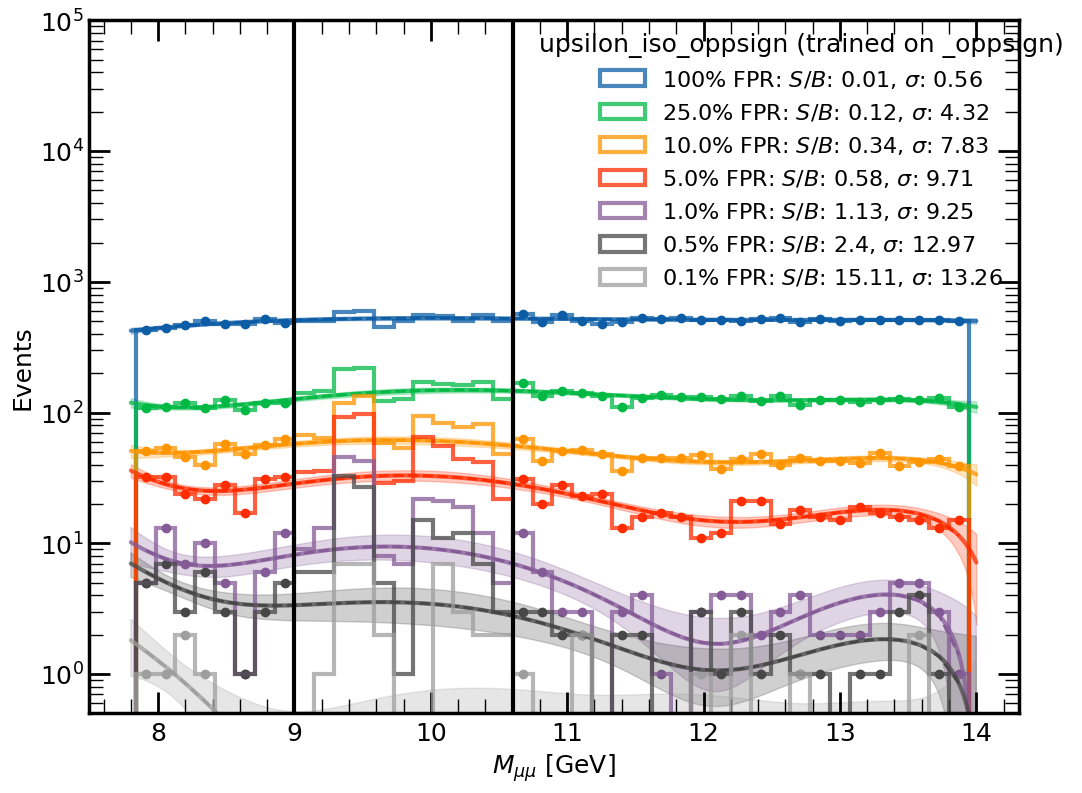

In [75]:

"""
PLOT HISTOGRAM ON SMALL TEST SET
"""
plot_histograms_with_fits(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"{particle_type}{train_data_id_title} (trained on {train_data_id_title})\n", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findf

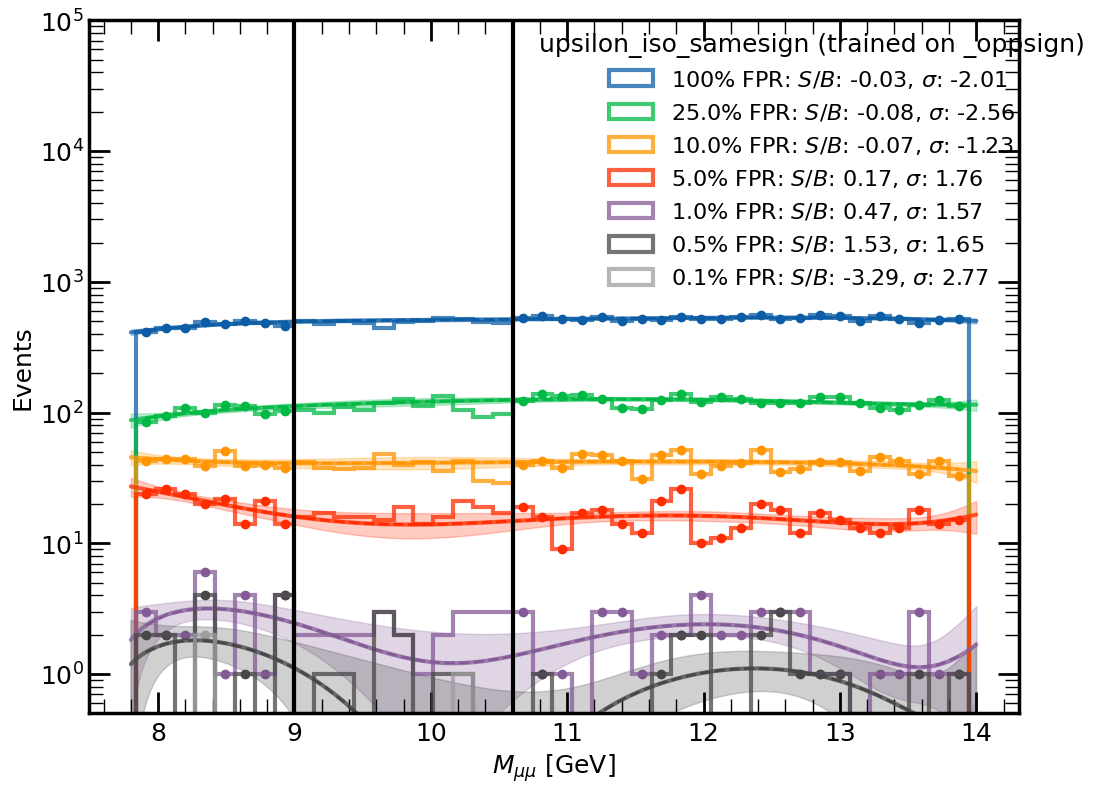

In [76]:


"""
PLOT HISTOGRAM ON ALTERNATIVE TEST SET
"""
plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], all_alt_scores_splits[pseudo_e_to_plot]["alt"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type, f"{particle_type}{alt_test_data_id} (trained on {train_data_id_title})\n",SB_left, SR_left, SR_right, SB_right, take_score_avg=False)





In [77]:
"""
PLOT HISTOGRAM ON ROC TEST DATA
"""
# this plot won't be shown in the main body -- this is just the high-stats set that is used to create the ROC curve

#plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_data"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_data"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats data _oppsign (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)



'\nPLOT HISTOGRAM ON ROC TEST DATA\n'

findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'seri

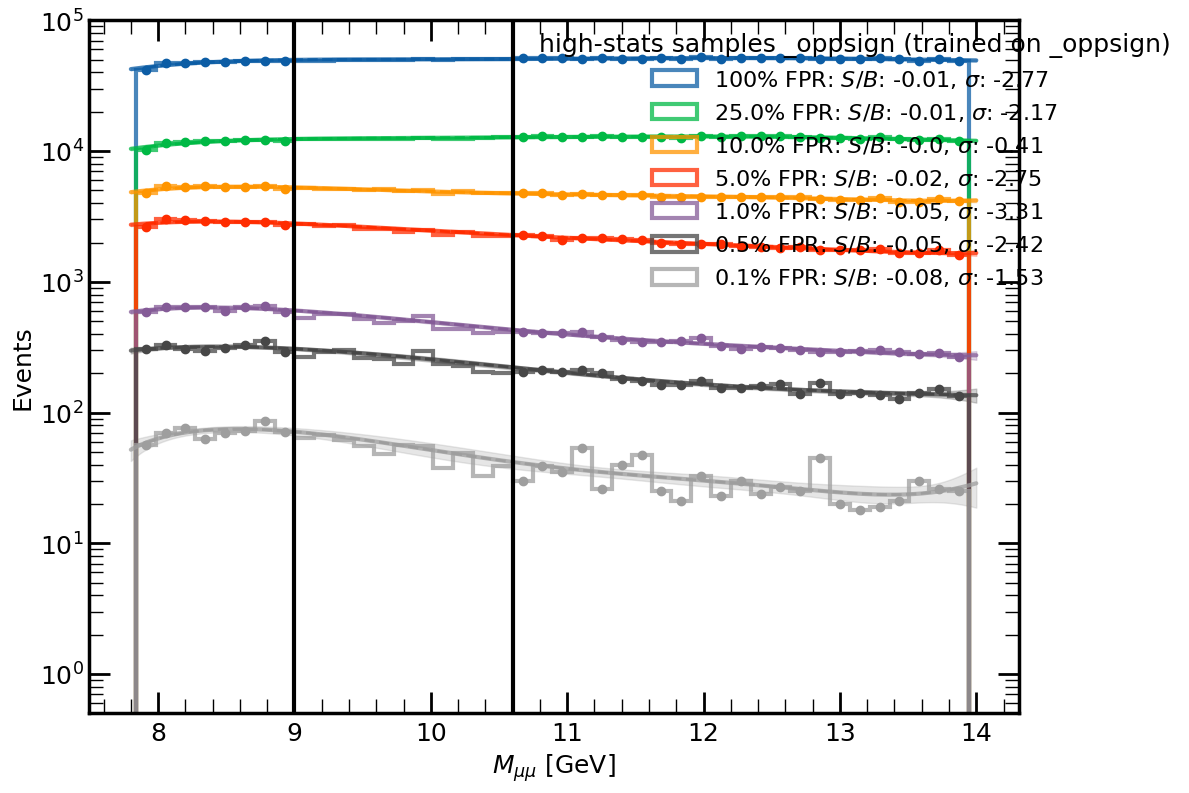

In [78]:
"""
PLOT HISTOGRAM ON FLOW SAMPLES
"""
plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_samples"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_samples"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats samples {train_data_id_title} (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


# Classical Studies

In [79]:
from helpers.plotting import feature_bins


def plot_feature_cuts(feature, fpr_thresholds, test_data_dict, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, flip = False):
    """
    Plot the feature cuts for the given data, scores, and score cutoffs.

    Parameters
    ----------
    feature : str
        The feature to plot the cuts for.
    fpr_thresholds : list
        The list of FPR thresholds to plot.
    test_data_dict : dict
        The dictionary of test data.
    mass_scalar : sklearn.preprocessing.StandardScaler
        The mass scaler.
    fit_type : str
        The type of fit to use for the background.
    title : str
        The title of the plot.
    SB_left : float
        The left side of the sideband.
    SR_left : float
        The left side of the signal region.
    SR_right : float
        The right side of the signal region.
    SB_right : float
        The right side of the sideband.
    """

        

    # Unpack the data dictionary to extract the feature of interest 
    feature_SBL = test_data_dict["SBL"]["s_inj_data"][feature]
    feature_SR = test_data_dict["SR"]["s_inj_data"][feature]
    feature_SBH = test_data_dict["SBH"]["s_inj_data"][feature]

    if flip:
        feature_SBL = -feature_SBL
        feature_SR = -feature_SR
        feature_SBH = -feature_SBH

    # Unpack the data dictionary to extract the dimuon mass spectrum
    mass_SBL = mass_scalar.inverse_transform(np.array(test_data_dict["SBL"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
    mass_SR = mass_scalar.inverse_transform(np.array(test_data_dict["SR"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))
    mass_SBH = mass_scalar.inverse_transform(np.array(test_data_dict["SBH"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))

    # Get a list of all possible cuts for the feature
    feature_cut_points = np.linspace(np.min(feature_SBL), np.max(feature_SBH), 1000)

    # For each cut, calculate the number of signal and background events in the SR
    num_in_SBL = []
    num_in_SR = []
    num_in_SBH = []
    FPR = []
    for cut in feature_cut_points:
        num_in_SBL.append(np.sum(feature_SBL >= cut))
        num_in_SR.append(np.sum(feature_SR >= cut))
        num_in_SBH.append(np.sum(feature_SBH >= cut))


        # @RADHA: I am estimating the FPR of each cut by the amount the sideband gets reduced. I cannot parse how you have done it above.
        # FPR is the combination of SBH and SBL
        FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))

    
    # Set up fit types
    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = 12)

    fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}


    # fig, ax = newplot("full", aspect_ratio = 1.5)
    fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)
    for t, threshold in enumerate(fpr_thresholds):


        # Use interpolation to find the cut point that gives the desired FPR
        best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]

        # Make the cuts to both the feature and the mass
        feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
        feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
        feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

        mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
        mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
        mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

        # Concatenate to get the full mass spectrum
        filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
        

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)
        
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    

        # calculate significance of bump
        num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt)
        y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
        B_error = np.sqrt(np.sum(y_err**2))
        S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
        significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)

        label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(S_over_B,2))+", $\sigma$: "+str(round(significance,2))


        hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string, alpha_1 = 0.1, alpha_2 = 0.5)
        # plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")




    legend_title = rf"Upsilon {feature}: Iso, Opp. Sign"
    plt.legend(loc = (0.475, 0.6), fontsize = 16, title = title[:-1])


    plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
    plt.ylabel("Events", fontsize = 18)

    plt.yscale("log")
    plt.ylim(0.5, 1e5)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)

    



<>:113: SyntaxWarning: invalid escape sequence '\s'
<>:130: SyntaxWarning: invalid escape sequence '\m'
<>:113: SyntaxWarning: invalid escape sequence '\s'
<>:130: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_380576/3627868176.py:113: SyntaxWarning: invalid escape sequence '\s'
  label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(S_over_B,2))+", $\sigma$: "+str(round(significance,2))
/tmp/ipykernel_380576/3627868176.py:130: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


dimu_pt


mu0_ip3d


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


mu1_ip3d


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following famil

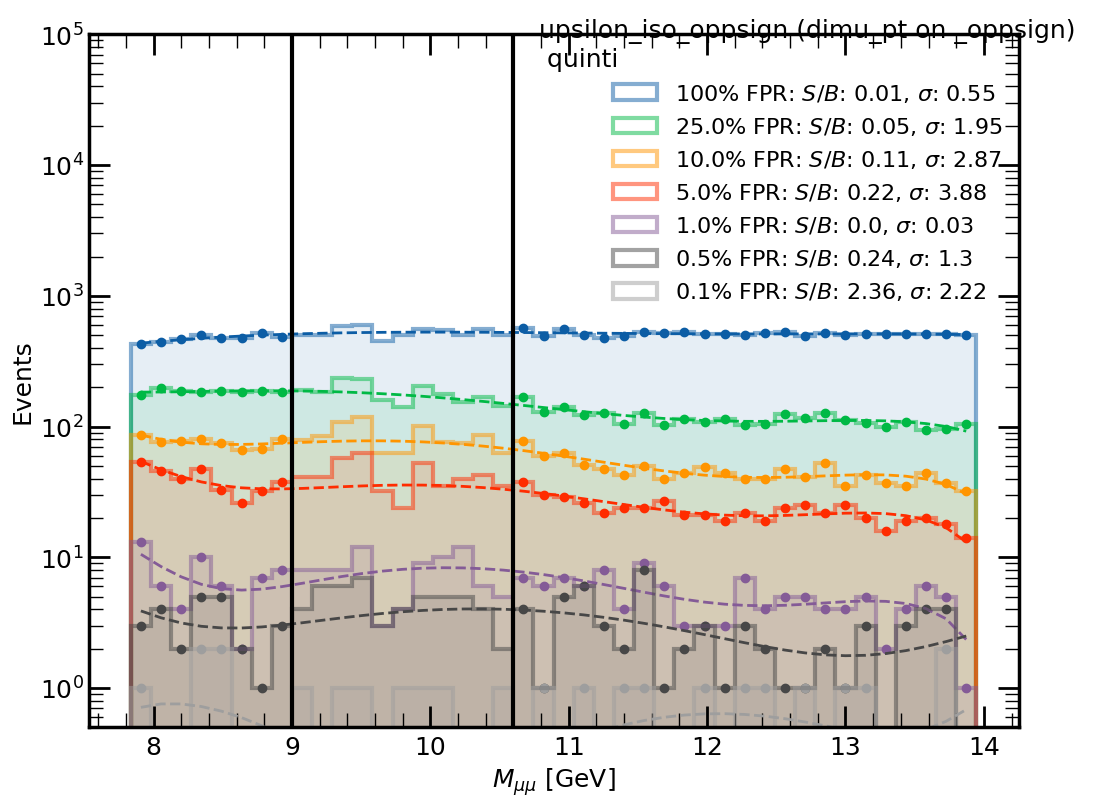

findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'seri

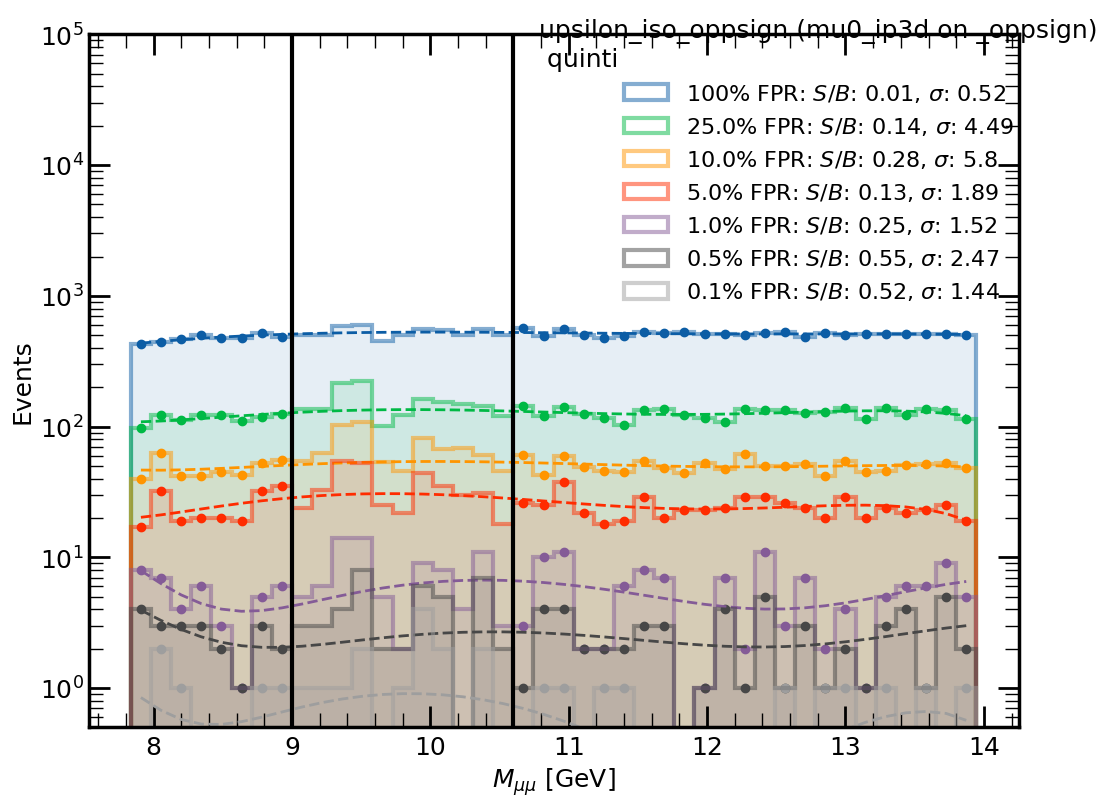

findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'seri

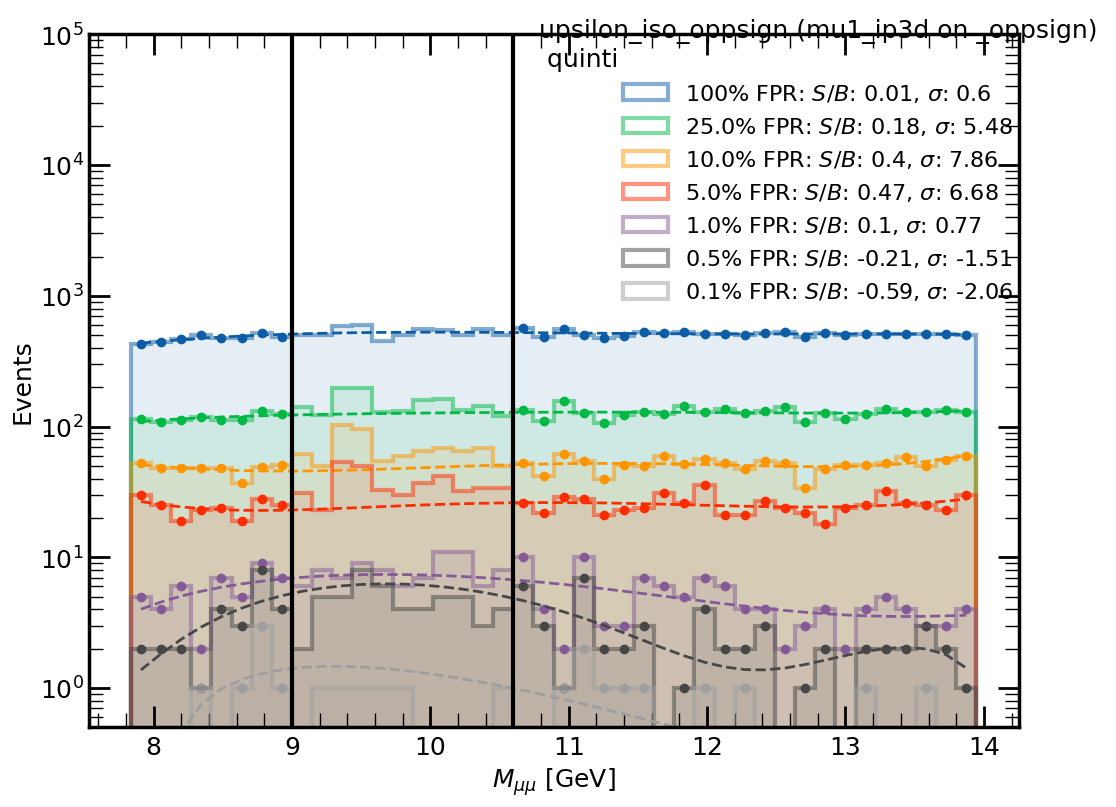

In [80]:
flip_features = [False, True, True]
for feature in feature_set[:-1]:
    print(feature)
    fpr_results_quintic = plot_feature_cuts(feature, fpr_thresholds, test_data_dict, scaler, "quintic", f"{particle_type}{train_data_id_title} ({feature} on {train_data_id_title})\n quintic", SB_left, SR_left, SR_right, SB_right, flip = flip_features[feature_set.index(feature)])



# Plot ROC

In [81]:
fit_type = "quintic"
fit_function = bkg_fit_quintic

In [82]:
"""
CALCULATE THE ROC CURVES
"""

# determine fpr thresholds as before
# yes this is repeated code
fpr_thresholds_finegrained = np.logspace(0, -3, 20)
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = 24)


# first determine score cutoffs
score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds_finegrained:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff

        
def get_classifier_metrics_high_stats(dataset_id, score_cutoffs):
            
    S_yield, B_yield = np.empty((fpr_thresholds_finegrained.shape[0], num_pseudoexperiments)), np.empty((fpr_thresholds_finegrained.shape[0], num_pseudoexperiments))

    for pseudo_e in range(num_pseudoexperiments):

        print(f"On pseudo experiment {pseudo_e+1}...")
        for t, threshold in enumerate(fpr_thresholds_finegrained):

            filtered_masses_bs = []

            for i_fold in range(n_folds):
                loc_true_masses_bs = scaler.inverse_transform(np.array(all_alt_data_splits[pseudo_e][dataset_id][i_fold][:,-1]).reshape(-1,1))
                loc_scores_bs = all_alt_scores_splits[pseudo_e][dataset_id][i_fold]
                # filter top event based on score cutoff
                loc_filtered_masses_bs, _, _, _ = select_top_events_fold(loc_true_masses_bs, loc_scores_bs, score_cutoffs[pseudo_e][i_fold][threshold], plot_bins_left, plot_bins_right, plot_bins_SR)
                filtered_masses_bs.append(loc_filtered_masses_bs)

            filtered_masses_bs = np.concatenate(filtered_masses_bs)
            # get the fit function to SB background
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses_bs, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
            num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses_bs, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt)
        
            S_yield[t, pseudo_e] = num_S_expected_in_SR
            B_yield[t, pseudo_e] = num_B_expected_in_SR
        
    # calculate summary stats
    TPR = S_yield/S_yield[0,:]
    FPR = B_yield/B_yield[0,:]
    

    ROC = 1.0/FPR

    SIC = TPR/np.sqrt(FPR)
    
    return TPR, FPR, ROC, SIC



In [83]:
print(all_test_data_splits)

{0: {0: array([[-1.03777933,  0.28696251, -0.76810682, -1.04598784],
       [-0.39823067,  0.08341233, -1.06092441, -1.11084712],
       [-0.2063636 , -0.11867414,  0.225182  , -1.0076195 ],
       ...,
       [-0.36707625, -0.26214981, -0.97061896, -1.62871552],
       [ 0.38731623,  0.52053446, -0.41975883,  1.42594886],
       [ 1.55911314, -0.48868516,  1.27732694, -1.93333912]]), 1: array([[-0.39381045, -0.79432839, -0.40573099, -1.04096544],
       [-0.29709312, -0.57677221, -0.04818312, -0.87894338],
       [-1.16127288,  0.65171468,  0.10147242, -1.30692184],
       ...,
       [-0.45120752,  0.36967003, -0.70190167,  0.51072431],
       [ 1.63276899, -1.19682038,  1.67886186,  1.30618536],
       [-1.2573123 ,  0.09119125,  0.94883835, -0.37959138]]), 2: array([[ 0.46346125, -0.83626872,  1.42832255, -1.12702751],
       [ 2.02081203, -1.15625083, -0.565422  , -1.1074245 ],
       [ 1.60181689,  0.42900684, -1.13418806, -1.33776891],
       ...,
       [ 0.93981868,  0.8279859

In [ ]:
from helpers.plotting import feature_bins


def feature_cut_ROCS(feature, test_data_dict, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, flip = False, index = 0):
    """
    Plot the feature cuts for the given data, scores, and score cutoffs.

    Parameters
    ----------
    feature : str
        The feature to plot the cuts for.
    fpr_thresholds : list
        The list of FPR thresholds to plot.
    test_data_dict : dict
        The dictionary of test data.
    mass_scalar : sklearn.preprocessing.StandardScaler
        The mass scaler.
    fit_type : str
        The type of fit to use for the background.
    title : str
        The title of the plot.
    SB_left : float
        The left side of the sideband.
    SR_left : float
        The left side of the signal region.
    SR_right : float
        The right side of the signal region.
    SB_right : float
        The right side of the sideband.
    """






    fpr_thresholds = np.linspace(0, 1, 100)[::-1]
    signal_yeilds = np.zeros((len(fpr_thresholds), 500))
    background_yields = np.zeros((len(fpr_thresholds), 500))
    background_errors = np.zeros((len(fpr_thresholds), 500))

    # Unpack the data dictionary to extract the feature of interest 
    feature_SBL = test_data_dict["SBL"]["s_inj_data"][feature]
    feature_SR = test_data_dict["SR"]["s_inj_data"][feature]
    feature_SBH = test_data_dict["SBH"]["s_inj_data"][feature]

    if flip:
        feature_SBL = -feature_SBL
        feature_SR = -feature_SR
        feature_SBH = -feature_SBH

    # Unpack the data dictionary to extract the dimuon mass spectrum
    mass_SBL_0 = mass_scalar.inverse_transform(np.array(test_data_dict["SBL"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))[:,0]
    mass_SR_0 = mass_scalar.inverse_transform(np.array(test_data_dict["SR"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))[:,0]
    mass_SBH_0 = mass_scalar.inverse_transform(np.array(test_data_dict["SBH"]["s_inj_data"]["dimu_mass"]).reshape(-1,1))[:,0]

    # Get a list of all possible cuts for the feature
    feature_cut_points = np.linspace(np.min(feature_SBL), np.max(feature_SBH), 1000)

    # For each cut, calculate the number of signal and background events in the SR
    num_in_SBL = []
    num_in_SR = []
    num_in_SBH = []
    FPR = []
    for cut in feature_cut_points:
        num_in_SBL.append(np.sum(feature_SBL >= cut))
        num_in_SR.append(np.sum(feature_SR >= cut))
        num_in_SBH.append(np.sum(feature_SBH >= cut))


        # @RADHA: I am estimating the FPR of each cut by the amount the sideband gets reduced. I cannot parse how you have done it above.
        # FPR is the combination of SBH and SBL
        FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))

    
    # Set up fit types
    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = 12)

    fpr_results = {threshold:{"S":0, "B":0, "S_over_B":0, "signif":0} for threshold in fpr_thresholds}


    for e in range(500):

        # Resample the masses
        # print(mass_SBL_cut_0.shape)
        mass_SBL = mass_SBL_0 + 0*np.random.choice(mass_SBL_0, size =  len(mass_SBL_0), replace = True)
        mass_SBH = mass_SBH_0 + 0*np.random.choice(mass_SBH_0, size =  len(mass_SBH_0), replace = True)
        mass_SR = mass_SR_0 + 0*np.random.choice(mass_SR_0, size =  len(mass_SR_0), replace = True)

        # fig, ax = newplot("full", aspect_ratio = 1.5)
        for t, threshold in enumerate(fpr_thresholds):


            # Use interpolation to find the cut point that gives the desired FPR
            best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]

            # Make the cuts to both the feature and the mass
            feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
            feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
            feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

            mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
            mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
            mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]



            # Concatenate to get the full mass spectrum
            filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
            

            # get the fit function to SB background
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
            #print("chi2/dof:", chi2/n_dof)
            

            # calculate significance of bump
            num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt)
            y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
            B_error = np.sqrt(np.sum(y_err**2))
            S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
            significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)


            signal_yeilds[t, e] =  num_S_expected_in_SR
            background_yields[t, e] =  num_B_expected_in_SR

        # print(f"Threshold: {threshold}, S: {num_S_expected_in_SR   }, B: {num_B_expected_in_SR  }, TPR: {num_S_expected_in_SR/signal_yeilds[0,0]  }, FPR: {num_B_expected_in_SR/background_yields[0,0]}")   




    TPR = signal_yeilds/signal_yeilds[0, :]
    FPR = background_yields/background_yields[0, :]

    ROC = 1.0/FPR

    SIC = TPR/np.sqrt(FPR)
    
    return TPR, FPR, ROC, SIC


In [87]:
TPR, FPR, ROC, SIC = get_classifier_metrics_high_stats("ROC_data", score_cutoffs_finegrained)


On pseudo experiment 1...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 2...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 3...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 4...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 5...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 6...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 7...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 8...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 9...
On pseudo experiment 10...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 11...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 12...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 13...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 14...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 15...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 16...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 17...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 18...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 19...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 20...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 21...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 22...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 23...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 24...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 25...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 26...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 27...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 28...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 29...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 30...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 31...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 32...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 33...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 34...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 35...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 36...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 37...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 38...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 39...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 40...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 41...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 42...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 43...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 44...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 45...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 46...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 47...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 48...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 49...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


On pseudo experiment 50...


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


dimu_pt


/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: invalid value encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/physics_functions.py:104: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/tmp/ipykernel_380576/318652390.py:126: RuntimeWarning: invalid value encountered in sqrt
  significance = num_S_expected_in_SR/np.sqrt(num_B_expected_

findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'serif' not found because none of the following families were found: CM
findfont: Generic family 'seri

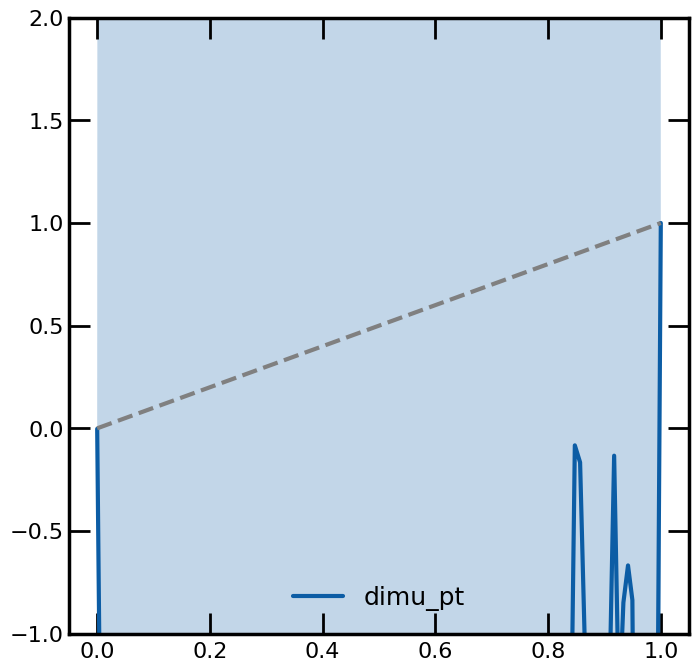

In [88]:



feature_TPRs = {}
feature_FPRs = {}
feature_ROCs = {}
feature_SICs = {}

flip_features = [False, True, True] 
for (i, feature) in enumerate(["dimu_pt"]):
    print(feature)
    feature_TPRs[feature], feature_FPRs[feature], feature_ROCs[feature], feature_SICs[feature] = feature_cut_ROCS(feature, test_data_dict, scaler, "quintic", f"{particle_type}{train_data_id_title} ({feature} on {train_data_id_title})\n quintic", SB_left, SR_left, SR_right, SB_right, flip = flip_features[i], index = i)
    plt.plot(feature_FPRs[feature].mean(axis = 1), feature_TPRs[feature].mean(axis = 1), label = feature)

    # band 
    feature_TPRS_mean = feature_TPRs[feature].mean(axis = 1)
    feature_TPRS_std = feature_TPRs[feature].std(axis = 1)

    feature_FPRS_mean = feature_FPRs[feature].mean(axis = 1)
    feature_FPRS_std = feature_FPRs[feature].std(axis = 1)

    plt.fill_between(feature_FPRS_mean, feature_TPRS_mean-feature_TPRS_std, feature_TPRS_mean+feature_TPRS_std, alpha = 0.25)

plt.ylim(-1, 2)
plt.plot([0, 1], [0, 1], linestyle = "--", color = "grey")

plt.legend()



In [86]:
# Add the ordinary TPR, FPR, ROC, SIC to dictionary with key "CATHODE"
feature_TPRs["CATHODE"] = TPR
feature_FPRs["CATHODE"] = FPR
feature_ROCs["CATHODE"] = ROC
feature_SICs["CATHODE"] = SIC


NameError: name 'TPR' is not defined

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


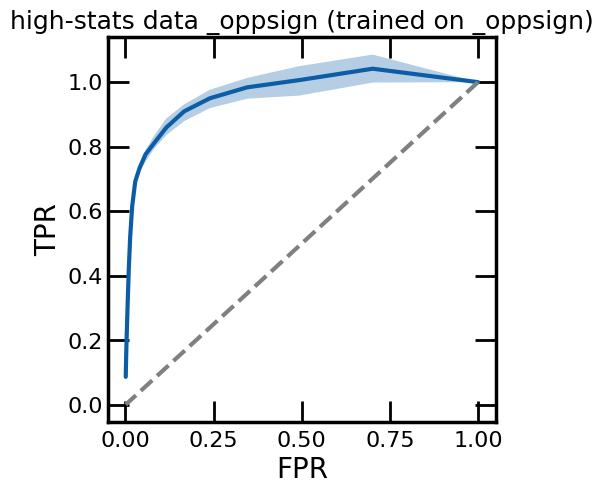

In [ ]:
     
TPR_median, TPR_lower, TPR_upper = get_median_percentiles(TPR)
FPR_median, FPR_lower, FPR_upper = get_median_percentiles(FPR)
ROC_median, ROC_lower, ROC_upper = get_median_percentiles(ROC)
SIC_median, SIC_lower, SIC_upper = get_median_percentiles(SIC)

plt.figure(figsize = (5, 5))
plt.plot(FPR_median, TPR_median)
plt.fill_between(FPR_median, TPR_lower, TPR_upper, alpha = 0.3 )
plt.plot(FPR_median, FPR_median, linestyle = "dashed", color = "grey")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f"high-stats data _oppsign (trained on {train_data_id_title})")
plt.show()



/global/homes/r/rikab/.conda/envs/rikab/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


(0.0, 6.0)

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


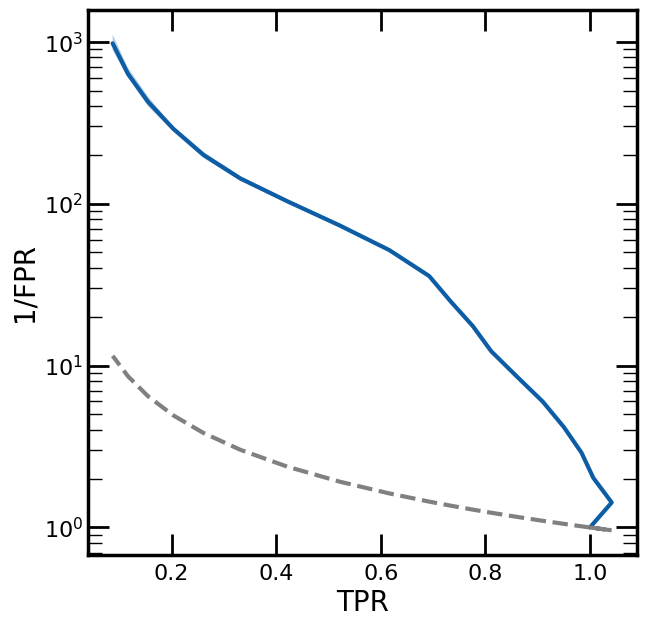

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


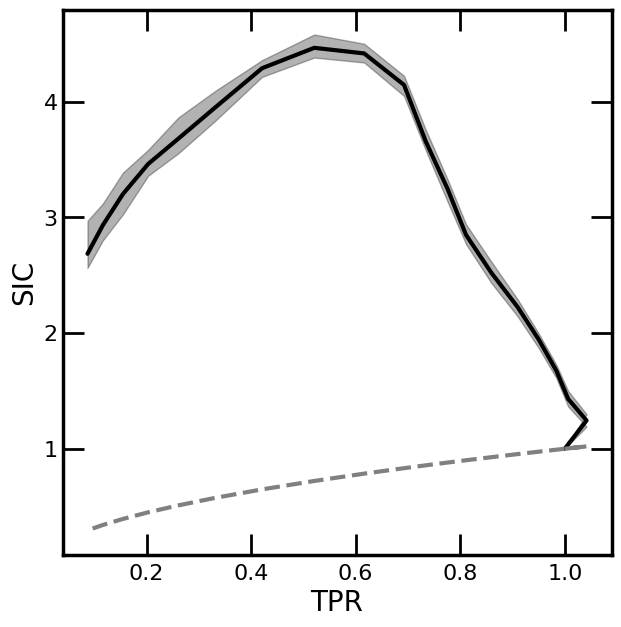

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


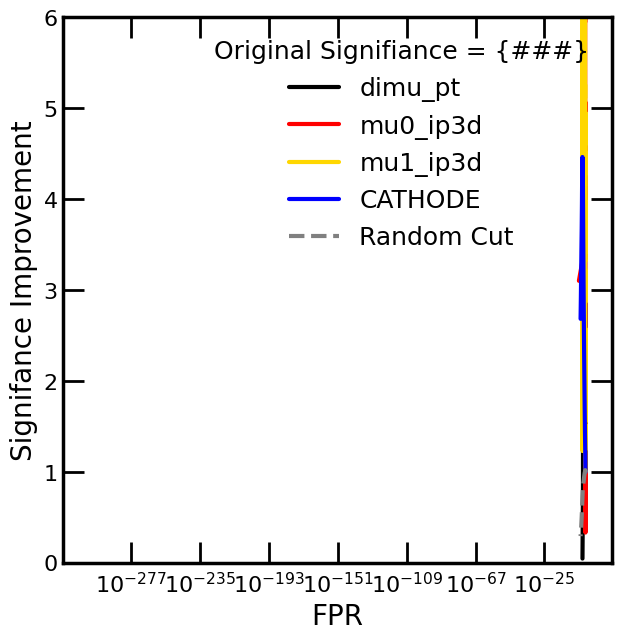

In [ ]:

fig, ax = newplot("full", use_tex = latex_flag)
ax.plot(TPR_median, ROC_median)
ax.fill_between(TPR_median, ROC_lower, ROC_upper, alpha = 0.3 )
ax.plot(TPR_median, 1.0/TPR_median, linestyle = "dashed", color = "grey")
ax.set_xlabel("TPR")
ax.set_ylabel("1/FPR")
ax.set_yscale("log")


fig, ax = newplot("full", use_tex = latex_flag)
ax.plot(TPR_median, SIC_median, color = "black")
ax.fill_between(TPR_median, SIC_lower, SIC_upper, alpha = 0.3, color = "black")
ax.plot(TPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey")
ax.set_xlabel("TPR")
ax.set_ylabel("SIC")

# FPR Variant of SIC
fig, ax = newplot("full", use_tex = latex_flag)
colors = ["black", "red", "gold", "blue"]
for (i, key) in enumerate(feature_SICs.keys()):

    TPR_median, TPR_lower, TPR_upper = get_median_percentiles(feature_TPRs[key])
    FPR_median, FPR_lower, FPR_upper = get_median_percentiles(feature_FPRs[key])
    ROC_median, ROC_lower, ROC_upper = get_median_percentiles(feature_ROCs[key])
    SIC_median, SIC_lower, SIC_upper = get_median_percentiles(feature_SICs[key])

    ax.plot(FPR_median, SIC_median, color = colors[i], label = key)
    ax.fill_between(FPR_median, SIC_lower, SIC_upper, alpha = 0.3, color = colors[i])
ax.plot(FPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey", label = "Random Cut")
ax.set_xlabel("FPR")
ax.set_ylabel("Signifance Improvement")

legend_title = "Original Signifiance = {###}"
plt.legend(title = legend_title, loc = "upper right")
plt.xscale("log")
plt.ylim(0, 6)


# ax.plot(FPR_median, SIC_median, color = "black", label = r"CATHODE")
# ax.fill_between(FPR_median, SIC_lower, SIC_upper, alpha = 0.3, color = "black")
# ax.plot(FPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey", label = "Random Cut")
# ax.set_xlabel("FPR")
# ax.set_ylabel("Signifance Improvement")

# legend_title = "Original Signifiance = {###}"
# plt.legend(title = legend_title, loc = "upper right")
# plt.xscale("log")
# plt.ylim(0, 6)